## import packages

In [8]:
import netneurotools as nnt
from scipy.stats._stats_py import _chk2_asarray
import shutil

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import pyls # PLS: behavioral and mean-centered
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis

import pathlib

###################### update path!! #####################################
base_path = '/root_dir/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

## functions

In [9]:
## copied from netneurotools: https://github.com/netneurolab/netneurotools/blob/master/netneurotools/stats.py
def permtest_rel(a, b, axis=0, n_perm=1000, seed=0):
    """
    Non-parametric equivalent of :py:func:`scipy.stats.ttest_rel`
    Generates two-tailed p-value for hypothesis of whether related samples `a`
    and `b` differ using permutation tests
    Parameters
    ----------
    a, b : array_like
        Sample observations. These arrays must have the same shape.
    axis : int or None, optional
        Axis along which to compute test. If None, compute over whole arrays
        of `a` and `b`. Default: 0
    n_perm : int, optional
        Number of permutations to assess. Unless `a` and `b` are very small
        along `axis` this will approximate a randomization test via Monte
        Carlo simulations. Default: 1000
    seed : {int, np.random.RandomState instance, None}, optional
        Seed for random number generation. Set to None for "randomness".
        Default: 0
    Returns
    -------
    stat : float or numpy.ndarray
        Average difference between `a` and `b`
    pvalue : float or numpy.ndarray
        Non-parametric p-value
    Notes
    -----
    The lowest p-value that can be returned by this function is equal to 1 /
    (`n_perm` + 1).
    Examples
    --------
    >>> from netneurotools import stats
    >>> np.random.seed(12345678)  # set random seed for reproducible results
    >>> rvs1 = np.random.normal(loc=5, scale=10, size=500)
    >>> rvs2 = (np.random.normal(loc=5, scale=10, size=500)
    ...         + np.random.normal(scale=0.2, size=500))
    >>> stats.permtest_rel(rvs1, rvs2)  # doctest: +SKIP
    (-0.16506275161572695, 0.8021978021978022)
    >>> rvs3 = (np.random.normal(loc=8, scale=10, size=500)
    ...         + np.random.normal(scale=0.2, size=500))
    >>> stats.permtest_rel(rvs1, rvs3)  # doctest: +SKIP
    (2.40533726097883, 0.000999000999000999)
    """

    a, b, axis = _chk2_asarray(a, b, axis)
    rs = check_random_state(seed)

    if a.shape[axis] != b.shape[axis]:
        raise ValueError('Provided arrays do not have same length along axis')

    if a.size == 0 or b.size == 0:
        return np.nan, np.nan

    # calculate original difference in means
    ab = np.stack([a, b], axis=0)
    if ab.ndim < 3:
        ab = np.expand_dims(ab, axis=-1)
    true_diff = np.squeeze(np.diff(ab, axis=0)).mean(axis=axis) / 1
    abs_true = np.abs(true_diff)

    # idx array
    reidx = np.meshgrid(*[range(f) for f in ab.shape], indexing='ij')

    permutations = np.ones(true_diff.shape)
    for perm in range(n_perm):
        # use this to re-index (i.e., swap along) the first axis of `ab`
        swap = rs.random_sample(ab.shape[:-1]).argsort(axis=axis)
        reidx[0] = np.repeat(swap[..., np.newaxis], ab.shape[-1], axis=-1)
        # recompute difference between `a` and `b` (i.e., first axis of `ab`)
        pdiff = np.squeeze(np.diff(ab[tuple(reidx)], axis=0)).mean(axis=axis)
        permutations += np.abs(pdiff) >= abs_true

    pvals = permutations / (n_perm + 1)  # + 1 in denom accounts for true_diff

    return true_diff, pvals

In [10]:
def process_img(stat_img, cluster_extent, voxel_thresh=1.96, direction='both'):
    """
    Parameters
    ----------
    stat_img : Niimg_like object
        Thresholded statistical map image
    cluster_extent : int
        Minimum number of voxels required to consider a cluster
    voxel_thresh : float, optional
        Threshold to apply to `stat_img`. Use `direction` to specify the
        directionality of the threshold. If a negative number is provided a
        percentile threshold is used instead, where the percentile is
        determined by the equation `100 - voxel_thresh`. Default: 1.96
    direction : str, optional
        Specifies the direction in which `voxel_thresh` should be applied.
        Possible values are 'both', 'pos' or 'neg'. Default: 'both'
    Returns
    -------
    cluster_img : Nifti1Image
        4D image of brain regions, where each volume is a distinct cluster
    """
    # get input data image
    img_4d = check_niimg(stat_img, atleast_4d=True)
    if img_4d.shape[-1] == 1:
        stat_img = img_4d.slicer[..., 0]
    else:
        stat_img = image.index_img(img_4d, 0)

    # threshold image
    if voxel_thresh < 0:
        voxel_thresh = '{}%'.format(100 + voxel_thresh)
    else:
        # ensure that threshold is not greater than most extreme value in image
        if voxel_thresh > np.nan_to_num(np.abs(stat_img.get_fdata())).max():
            empty = np.zeros(stat_img.shape + (1,))
            return image.new_img_like(stat_img, empty)
    thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)

    # extract clusters
    min_region_size = cluster_extent * np.prod(thresh_img.header.get_zooms())
    clusters = []

    if direction == 'both':
        direction_list = ['pos', 'neg']
    elif direction == 'pos':
        direction_list = ['pos']
    elif direction == 'neg':
        direction_list = ['neg']

    for sign in direction_list:
        # keep only data of given sign
        data = thresh_img.get_fdata().copy()
        data[(data < 0) if sign == 'pos' else (data > 0)] = 0

        # Do nothing if data array contains only zeros
        if np.any(data):
            try:
                if min_region_size != 0.0:
                    min_region_size -= 1e-8
                clusters += [connected_regions(
                    image.new_img_like(thresh_img, data),
                    min_region_size=min_region_size,
                    extract_type='connected_components')[0]]
            except TypeError:  # for no clusters
                pass

    # Return empty image if no clusters were found
    if len(clusters) == 0:
        return image.new_img_like(thresh_img, np.zeros(data.shape + (1,)))

    # Reorder clusters by their size
    clust_img = image.concat_imgs(clusters)
    cluster_size = (clust_img.get_fdata() != 0).sum(axis=(0, 1, 2))
    new_order = np.argsort(cluster_size)[::-1]
    clust_img_ordered = image.index_img(clust_img, new_order)

    return 

## define variables (please check!!)

In [11]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'
MNI_2mm_brain = derivatives_dir + '/MNI152_T1_2mm_brain.nii.gz'

sns.set_style("whitegrid")

coords=(-15, 0, 15, 30, 45, 60, 75, 90)

In [319]:
## Please which OEF / R2' / CMRO2 version to use ##
###################################################

#CMRO2_mode = 'orig' ## orig = CMRO2 maps NOT corrected for CBV changes, only CMRO2 maps of subj > 55 in CALC condition are corrected for CBV increases
CMRO2_mode = 'corrected' ## CMRO2 CALC maps corrected for CBV changes (but MEM maps are not corrected)

## Please specify task & baseline ##
####################################

baseline='rest'
#baseline='control'
task='calc'
#task='mem'
conds = [baseline, task]
contrast=task+baseline

## Please specify subject list##
################################

if baseline == 'control' and task == 'calc':
    #N=40
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
else: #N=30, without p053
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]


##########################################################
## please select which group task mask to apply!! ##
##########################################################

#masks = ['Yeo', 'PLS BOLD', 'PLS CBF', 'GLM BOLD']
#masks = ['PLS CBF', 'PLS CMRO2', 'PLS OEF']
group_mask = [ 'PLS BOLD'] ## this is the PLS BOLD group mask
#masks = [ 'PLS CBF']
#masks = ['GLM_BOLD']


### other variables ##############
##################################

N_subj = str(len(sids))
GM_thresh = 0.5
BSR_thr=2

## Gray-matter mask, excluding areas with low signal-to-noise ratio according to fMRI data

YEO_SNR_mask = os.path.join( derivatives_dir, 'task-all_space-MNI152_res-2_SNR_YEO_group_mask.nii.gz')
mask_img = nib.load(YEO_SNR_mask)
maskerGM = input_data.NiftiMasker(mask_img=YEO_SNR_mask) ## exclude areas with too less SNR (based on the localizer data)
#mask_arr = np.array(mask_img.dataobj)

### BlueRed color palette

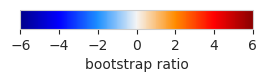

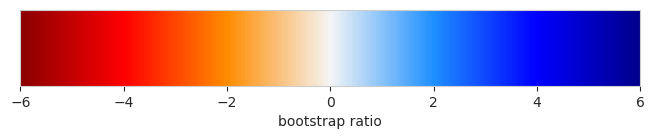

In [13]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

colors = ["darkblue", "blue", "dodgerblue",  "whitesmoke","darkorange", "red", "darkred"]
BlueRed = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(3,0.5))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed), 
             cax=ax, ticks=bounds, orientation='horizontal', label='bootstrap ratio')

## inverted colormap: BlueRed_r
colors = [ "darkred","red", "darkorange", "whitesmoke", "dodgerblue", "blue","darkblue"]
BlueRed_r = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(8, 2))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed_r), 
             cax=ax, ticks=bounds, orientation='horizontal', label='bootstrap ratio')

## Fig. 2B: Percent-signal change values within PLS mask (pos & neg separately)

In [ ]:
fontsize = 25
plt.rcParams['legend.title_fontsize'] = 'x-large'
sns.set_style("whitegrid")

##########################################################
## please select which parameters you want to look at! ##
##########################################################
parameters = ['func',  'cbf','cmro2']
#parameters = ['func']

df_percchange_median = pd.DataFrame(columns=parameters)
df_percchange_subj = pd.DataFrame(columns=parameters)
df_percchange_vox = pd.DataFrame(columns=parameters)

for mask in group_mask:
    

    if mask == 'PLS BOLD':
        BSR_pos_nii_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+ '_pos_bin.nii.gz'
        plotting.plot_img(BSR_pos_nii_mask, bg_img = MNI_2mm_brain, cmap=BlueRed, cut_coords=(10, 20, 30, 40), display_mode='z',colorbar = True, threshold=0, vmin = 0, vmax = 1, title= 'new mask')
        masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
        pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
        BSR_neg_nii_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_neg_bin.nii.gz'
        plotting.plot_img(BSR_neg_nii_mask,bg_img = MNI_2mm_brain,  cmap=BlueRed, cut_coords=(10, 20, 30, 40), display_mode='z',colorbar = True, threshold=0,vmin = 0, vmax = 1, title= 'new mask')
        masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
        neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)
    if mask == 'PLS CBF':
        BSR_pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz' + '_pos.nii.gz'
        masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
        pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
        BSR_neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz' + '_neg.nii.gz'
        masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
        neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)
    if mask == 'PLS CMRO2':
        BSR_pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz' + '_pos.nii.gz'
        masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
        pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
        BSR_neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz' + '_neg.nii.gz'
        masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
        neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)

    for par in parameters: 
        print(par)
        percchange_pos = np.zeros((len(sids), len(np.argwhere(pos_img))))
        percchange_neg = np.zeros((len(sids), len(np.argwhere(neg_img))))
    
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            #load percent signal change image
            if par == 'func':
                #percchange_img = nib.load(dir_func_deriv + '/' + sub + '_task-' + task + baseline + '_space-MNI152_BOLD_percchange.nii.gz')
                percchange_img = dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_desc-fmriprep_BOLD_percchange.nii.gz'
                #percchange_img = nib.load(dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_BOLD_percchange_desc-preproc.nii.gz')
                percchange_arr_pos = masker_pos.fit_transform(percchange_img)
                percchange_arr_neg = masker_neg.fit_transform(percchange_img)
            if par !='func' and par !='cmro2':
                par_map_task = dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_' + par + '.nii.gz'
                par_map_baseline = dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_' + par + '.nii.gz'
            if par =='cmro2':
                if task == 'calc':
                    par_map_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-CBV_' + par + '.nii.gz'
                if task !='calc':
                    par_map_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-orig_' + par + '.nii.gz'   
                par_map_baseline =  dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_' + par + '.nii.gz'                

                
            task_arr_pos = masker_pos.fit_transform(par_map_task)
            task_arr_neg = masker_neg.fit_transform(par_map_task)
            baseline_arr_pos = masker_pos.fit_transform(par_map_baseline)
            baseline_arr_neg = masker_neg.fit_transform(par_map_baseline)
            if par != 'func':
                percchange_arr_pos = (task_arr_pos - baseline_arr_pos) / baseline_arr_pos *100
                percchange_arr_neg = (task_arr_neg - baseline_arr_neg) / baseline_arr_neg *100
            
            
            percchange_pos[i,:] = percchange_arr_pos
            percchange_neg[i,:] = percchange_arr_neg
                    
        ## calculate median values across subjects
        percchange_median_pos = np.median(percchange_pos, axis=0)
        percchange_median_neg = np.median(percchange_neg, axis=0)
        df_percchange_vox[par] = [percchange_median_pos, percchange_median_neg]

        ## store median across voxels, per subject
        df_percchange_subj[par] =  [np.nanmedian(percchange_pos, axis=1), np.nanmedian(percchange_neg, axis=1)]
            
        ## median across all voxels
        pos_median = np.nanmedian(percchange_median_pos)
        neg_median = np.nanmedian(percchange_median_neg)
        df_percchange_median[par]=[pos_median, neg_median]
        
        print(par + ' positive median: ' + str(pos_median))
        
        ## print interquartile range
        # First quartile (Q1) 
        Q1 = np.percentile(percchange_median_pos, 25, interpolation = 'midpoint') 
        # Third quartile (Q3) 
        Q3 = np.percentile(percchange_median_pos, 75, interpolation = 'midpoint') 
        # Interquaritle range (IQR) 
        IQR = Q3 - Q1 

        print('IQR positive:  ' + str(IQR))
        
        print(par + ' negative median: ' + str(neg_median))
        ## print interquartile range
        # First quartile (Q1) 
        Q1 = np.percentile(percchange_median_neg, 25, interpolation = 'midpoint') 
        # Third quartile (Q3) 
        Q3 = np.percentile(percchange_median_neg, 75, interpolation = 'midpoint') 
        # Interquaritle range (IQR) 
        IQR = Q3 - Q1 

        print('IQR negative:  ' + str(IQR))
            
        ## plot only BOLD masked values        
        fig,ax = plt.subplots(1)      
        

        if par == 'func': 
            ax.set_xlim(-1.5, 1.5)
            width = 0.01
            brange = (-1.3, 1.5)
            #brange_neg = (-2.5, 0.5)
        else:
            ax.set_xlim(-20, 30)
            width = 0.1
            brange= (-20, 30)
            
        sns.histplot(percchange_median_pos, ax=ax, color='darkorange', alpha=0.9, bins=500, binrange = brange, binwidth= width)
        sns.histplot(percchange_median_neg, ax=ax, color='dodgerblue', alpha=0.7,  bins=500, binrange=brange, binwidth=width)
        
        #[t, p_pos] = stats.ttest_1samp(a=percchange_median_pos, popmean=0)
        #[t, p_neg] = stats.ttest_1samp(a=percchange_median_neg, popmean=0)
        #print('p-value positive change: ' + str(round(p_pos, 3)))           
        #print('p-value negative change: ' + str(round(p_neg, 3)))         
        
        ymin,ymax = ax.get_ylim()
        max_val = ymax - (0.05*ymax)
        plt.vlines(0, 0, max_val, color='black', alpha=0.7, linestyles='dashed')
        #ax.set_ylim(0, max_val)
        ax.set_xlabel('%' + par, fontsize=fontsize)
        ax.set_ylabel('voxel count', fontsize =fontsize)
        #ax.set_title(N_subj + ' subjects:'  + ' ' +  par + ' ' + CMRO2_mode + ' % signal change within ' + mask + ' mask')
        ax.plot([pos_median, pos_median], [0, max_val], color='darkred')
        ax.plot([neg_median, neg_median], [0, max_val], color='darkblue')
        if par == 'func' and task == 'calc':
            ax.text(brange[1]-0.7*brange[1], 350, str(round(np.nanmedian(percchange_median_pos), 2))+' %', color='darkorange', fontsize=fontsize)
            ax.text(brange[1]-1.7*brange[1], 350, str(round(np.nanmedian(percchange_median_neg), 2))+' %', color='dodgerblue', fontsize=fontsize)
        if par == 'func' and task == 'mem':
            ax.text(brange[1]-0.7*brange[1], 200, str(round(np.nanmedian(percchange_median_pos), 2))+' %', color='darkorange', fontsize=fontsize)
            ax.text(brange[1]-1.7*brange[1], 200, str(round(np.nanmedian(percchange_median_neg), 2))+' %', color='dodgerblue', fontsize=fontsize)
        if par != 'func':
            ax.text(brange[1]-0.7*brange[1], 150, str(round(np.nanmedian(percchange_median_pos), 2))+' %', color='darkorange', fontsize=fontsize)
            ax.text(brange[1]-1.7*brange[1], 150, str(round(np.nanmedian(percchange_median_neg), 2))+' %', color='dodgerblue', fontsize=fontsize)
            
        ## plot median %change values as legend
        #ax.legend(fontsize=16, loc='upper right', bbox_to_anchor=(0.4, 1))
        #set x-tick and y-ticke label size
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
    
        for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

        fig.show()
        fig.savefig(results_dir + '/N' + N_subj +'_' + mask + '_'+ contrast + '_' + par+'_percchange_histogram.png', dpi=300, bbox_inches='tight')

### delta values 

In [ ]:
import scipy 
from scipy import stats
from sklearn.utils import check_random_state

fontsize = 25
plt.rcParams['legend.title_fontsize'] = 'x-large'


##########################################################
## please select which parameters you want to look at! ##
##########################################################
parameters = ['cbf','cmro2']
parameters = ['cbf','cmro2']

if mask == 'PLS BOLD':
        BSR_pos_nii_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+ '_pos_bin.nii.gz'
        plotting.plot_img(BSR_pos_nii_mask, bg_img = MNI_2mm_brain, cmap=BlueRed, cut_coords=(10, 20, 30, 40), display_mode='z',colorbar = True, threshold=0, vmin = 0, vmax = 1, title= 'new mask')
        masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
        pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
        BSR_neg_nii_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_neg_bin.nii.gz'
        plotting.plot_img(BSR_neg_nii_mask,bg_img = MNI_2mm_brain,  cmap=BlueRed, cut_coords=(10, 20, 30, 40), display_mode='z',colorbar = True, threshold=0,vmin = 0, vmax = 1, title= 'new mask')
        masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
        neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)
if mask == 'PLS CBF':
        BSR_pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz' + '_pos.nii.gz'
        masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
        pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
        BSR_neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz' + '_neg.nii.gz'
        masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
        neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)
if mask == 'PLS CMRO2':
        BSR_pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz' + '_pos.nii.gz'
        masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
        pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
        BSR_neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz' + '_neg.nii.gz'
        masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
        neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)


for par in parameters:
        delta_pos = np.zeros((len(sids), len(np.argwhere(pos_img))))
        delta_neg = np.zeros((len(sids), len(np.argwhere(neg_img))))
        task_pos = np.zeros((len(sids), len(np.argwhere(pos_img))))
        task_neg = np.zeros((len(sids), len(np.argwhere(neg_img))))
        baseline_pos = np.zeros((len(sids), len(np.argwhere(pos_img))))
        baseline_neg = np.zeros((len(sids), len(np.argwhere(neg_img))))
        
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            #load percent signal change image
            if par !='func' and par !='cmro2':
                par_map_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_' + par + '.nii.gz'               
                par_map_baseline = dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_' + par + '.nii.gz'

            if par =='cmro2':
                if task == 'calc':
                    par_map_task = dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-CBV_' + par + '.nii.gz'
                if task !='calc':
                    par_map_task = dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-orig_' + par + '.nii.gz'
                par_map_baseline =  dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_' + par + '.nii.gz'

                    
            task_arr_pos = masker_pos.fit_transform(par_map_task)
            task_arr_neg = masker_neg.fit_transform(par_map_task)
            baseline_arr_pos = masker_pos.fit_transform(par_map_baseline)
            baseline_arr_neg = masker_neg.fit_transform(par_map_baseline)
            delta_arr_pos = task_arr_pos - baseline_arr_pos
            delta_arr_neg = task_arr_neg - baseline_arr_neg

            delta_pos[i,:] = delta_arr_pos
            delta_neg[i,:] = delta_arr_neg
            task_pos[i,:] = task_arr_pos
            task_neg[i,:] = task_arr_neg
            baseline_pos[i,:] = baseline_arr_pos
            baseline_neg[i,:] = baseline_arr_neg
            
        ## calculate median values across subjects
        delta_median_pos = np.median(delta_pos, axis=0)
        delta_median_neg = np.median(delta_neg, axis=0)
        task_median_pos = np.median(task_pos, axis=0)
        task_median_neg = np.median(task_neg, axis=0)
        baseline_median_pos = np.median(baseline_pos, axis=0)
        baseline_median_neg = np.median(baseline_neg, axis=0)
        
        print(par)

        ##print baseline IQR ## 
        #######################
        # First quartile (Q1) 
        Q1 = np.percentile(baseline_median_pos, 25, interpolation = 'midpoint') 
        # Third quartile (Q3) 
        Q3 = np.percentile(baseline_median_pos, 75, interpolation = 'midpoint') 
        # Interquaritle range (IQR) 
        IQR = Q3 - Q1 
        print('baseline positive ROI: ' + str(np.nanmedian(baseline_median_pos)) + ', IQR: ' + str(IQR))
        # First quartile (Q1) 
        Q1 = np.percentile(baseline_median_neg, 25, interpolation = 'midpoint') 
        # Third quartile (Q3) 
        Q3 = np.percentile(baseline_median_neg, 75, interpolation = 'midpoint') 
        # Interquaritle range (IQR) 
        IQR = Q3 - Q1         
        print('baseline negative ROI: ' + str(np.nanmedian(baseline_median_neg))+ ', IQR: ' + str(IQR))
        
        ##print delta IQR ## 
        #######################
        # First quartile (Q1) 
        Q1 = np.percentile(delta_median_pos, 25, interpolation = 'midpoint') 
        # Third quartile (Q3) 
        Q3 = np.percentile(delta_median_pos, 75, interpolation = 'midpoint') 
        # Interquaritle range (IQR) 
        IQR = Q3 - Q1 
        print('baseline positive ROI: ' + str(np.nanmedian(delta_median_pos)) + ', IQR: ' + str(IQR))
        # First quartile (Q1) 
        Q1 = np.percentile(delta_median_neg, 25, interpolation = 'midpoint') 
        # Third quartile (Q3) 
        Q3 = np.percentile(delta_median_neg, 75, interpolation = 'midpoint') 
        # Interquaritle range (IQR) 
        IQR = Q3 - Q1         
        print('baseline negative ROI: ' + str(np.nanmedian(delta_median_neg))+ ', IQR: ' + str(IQR))
        
        
        ## test for normality: if significant,no normal distribution!
        stat_pos_norm, p_value_pos_norm= stats.normaltest(delta_median_pos, axis=0, nan_policy='propagate')
        stat_neg_norm, p_value_neg_norm= stats.normaltest(delta_median_neg, axis=0, nan_policy='propagate')
        print('normal distribution within positive BOLD mask, p-value: ' + str(p_value_pos_norm))
        print('normal distribution within negative BOLD mask, p-value: ' + str(p_value_neg_norm))

        ##permutation test, because data are smoothed/non-independent
        [true_diff_pos, p_pos] = permtest_rel(task_median_pos, baseline_median_pos, n_perm=2000)
        print('permutation statistics within BOLD pos regions: ' + str(round(p_pos, 6)))

        [true_diff_neg, p_neg] = permtest_rel(task_median_neg, baseline_median_neg, n_perm=2000)
        print('permutation statistics within BOLD neg regions: ' + str(round(p_neg, 6)))
        

        ## plot only BOLD masked values        
        fig,ax = plt.subplots(1)            

        if par == 'cbf':
            x_val = 2.1
            max_val = 90
            #max_val = 70
            ax.set_xlim(-8, 8)
            brange = (-8,8)
            width = brange[1]/500
            axis_title = 'Δ CBF [ml/100g/min]'
        if par == 'cmro2':
            #max_val = 400
            max_val = 90
            x_val = 0.6
            ax.set_xlim(-30,30)
            brange = (-30,30)
            width = brange[1]/500
            axis_title = 'Δ CMRO2 [μmol/100g/min]'

        
        sns.histplot(delta_median_pos, ax=ax, color='darkorange', alpha=0.9, bins=500, binrange = brange, binwidth= width)
        sns.histplot(delta_median_neg, ax=ax, color='dodgerblue', alpha=0.7,  bins=500, binrange=brange, binwidth=width)
        
        #max_val = ymax - (0.1*ymax)

        plt.vlines(0, 0, max_val, color='black', alpha=0.7, linestyles='dashed')
        #ax.set_xlim(-x_val, x_val)
        ax.set_ylim(0, max_val)
        ax.set_yticks((0, 20, 40, 60, 80))
        ax.set_xlabel(axis_title, fontsize=fontsize)
        ax.set_ylabel('voxel count', fontsize=fontsize)
        #ax.set_title(N_subj + ' subjects:'  + ' ' +  par + ' ' + CMRO2_mode + ' raw delta within ' + mask + ' mask')
        ax.plot([np.median(delta_median_pos), np.median(delta_median_pos)], [0, max_val], color='darkred')
        ax.plot([np.median(delta_median_neg), np.median(delta_median_neg)], [0, max_val], color='darkblue')
        # absolute median values as text in plot
        if par == 'cbf':
            if p_neg < 0.001:
                ax.text(brange[0]-0.05*brange[0], 65,''+ str(round(np.median(delta_median_neg), 1))+' ΔCBF\n (='+ str(round(df_percchange_median[par][1], 2))+' %)', color='dodgerblue', fontsize=fontsize)            
            else:
                ax.text(brange[0]-0.05*brange[0], 65, str(round(np.median(delta_median_neg), 1)), color='darkblue', fontsize=fontsize)            
            if p_pos < 0.001:
                ax.text(brange[1]-0.7*brange[1], 65, ''+str(round(np.median(delta_median_pos), 1))+' ΔCBF\n (='+ str(round(df_percchange_median[par][0], 2))+' %)', color='darkorange', fontsize=fontsize)
            else:    
                ax.text(brange[1]-0.7*brange[1], 65, str(round(np.median(delta_median_pos), 1)), color='darkred', fontsize=fontsize)
        if par == 'cmro2':
            if p_neg < 0.001:
                ax.text(brange[0]-1.3*brange[0], 55,''+ str(round(np.median(delta_median_neg), 1))+' ΔCMRO2\n (='+ str(round(df_percchange_median[par][1], 2))+' %)', color='dodgerblue', fontsize=fontsize)            
            else:
                ax.text(brange[0]-1.3*brange[0], 55, str(round(np.median(delta_median_neg), 1))+' ΔCMRO2', color='dodgerblue', fontsize=fontsize)            
            if p_pos < 0.001:
                ax.text(brange[1]-0.7*brange[1], 75,''+ str(round(np.median(delta_median_pos), 1))+' ΔCMRO2\n (='+ str(round(df_percchange_median[par][0],2))+' %)', color='darkorange', fontsize=fontsize)
            else:    
                ax.text(brange[1]-0.7*brange[1], 75, str(round(np.median(delta_median_pos), 1))+' ΔCMRO2', color='darkorange', fontsize=fontsize)
                
        print('median pos. delta value: ' + str(round(np.median(delta_median_pos), 4)))
        print('median neg. delta value: ' + str(round(np.median(delta_median_neg), 4)))
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
            
        ## plot median %change values as legend
        #ax.legend(fontsize=18, loc='upper right', bbox_to_anchor=(0.35, 1.05))
       
        for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)

        fig.show()
        fig.savefig(results_dir + '/N' + N_subj +'_mask_'  + mask + contrast + '_' + par+'_delta_histogram.png', dpi=300, bbox_inches='tight')


## Fig. S1E supplements: Which Yeo networks do PLS clusters belong to?

In [ ]:
### YEO networks
VIS = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_VIS.nii.gz')

SMN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_SMN.nii.gz')

DAN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_DAN.nii.gz')

VAN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_VAN.nii.gz')

LIM = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_LIM.nii.gz')

FPN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_FPN.nii.gz')

DMN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_DMN.nii.gz')


yeo_nw = [VIS, SMN, DAN, VAN, LIM, FPN, DMN]

In [ ]:
## which YEO networks are the voxels parts of

if group_mask[0] == 'PLS BOLD':
    BSR_pos_nii_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_pos_bin.nii.gz'
    masker_pos = input_data.NiftiMasker(mask_img = BSR_pos_nii_mask)        
    pos_img=masker_pos.fit_transform(BSR_pos_nii_mask)
    len_pos_img = len(np.argwhere(pos_img))

    BSR_neg_nii_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_neg_bin.nii.gz'
    masker_neg = input_data.NiftiMasker(mask_img = BSR_neg_nii_mask) 
    neg_img=masker_neg.fit_transform(BSR_neg_nii_mask)
    len_neg_img = len(np.argwhere(neg_img))

yeo_nw = [VIS, SMN, DAN, VAN, LIM, FPN, DMN]
nw_names = ['VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']
cmap = (mpl.colors.ListedColormap(['darkviolet',
                                   'dodgerblue',
                                   'forestgreen',
                                   'violet', 
                                   'palegoldenrod',
                                   'darkorange',
                                   'indianred']), np.linspace(0, 7.5,8))
colors=['indigo','dodgerblue',
                                   'forestgreen',
                                   'orchid', 
                                   'palegoldenrod',
                                   'darkorange',
                                   'brown']
nw_len_pos = pd.DataFrame()
nw_len_neg = pd.DataFrame()

for n, nw in enumerate(yeo_nw):
    nw_arr_pos = masker_pos.fit_transform(nw)
    len_vox_pos = len(np.argwhere(nw_arr_pos==1))
    nw_len_pos[nw_names[n]] = [(len_vox_pos)/nw_arr_pos.shape[1] * 100]
    
    nw_arr_neg = masker_neg.fit_transform(nw)
    len_vox_neg = len(np.argwhere(nw_arr_neg==1))
    nw_len_neg[nw_names[n]] = [(len_vox_neg)/nw_arr_neg.shape[1] * 100]
    
## define which wedges should be labeled
def my_autopct(pct):
    return ('%0.0f%%' % pct) if pct > 6 else ''

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    
patches, texts, autotexts = ax1.pie(np.squeeze(nw_len_neg.values), labels=['','','','','','',''],autopct = my_autopct, startangle = 79.5, explode = [0.03,0.03,0.03,0.03,0.03,0.03,0.03],
        textprops = {'fontsize':25}, colors=colors, wedgeprops = {'linewidth': 6, 'alpha':0.9}, center = (0.1,0.1))
autotexts[0].set_color('lightgray')
#autotexts[1].set_color('lightgray')

ax1.set_title('negative BOLD voxels')

patches, texts, autotexts = ax2.pie(np.squeeze(nw_len_pos.values), labels=['','','','','','',''],autopct = my_autopct, startangle = 79.5, explode = [0.03,0.03,0.03,0.03,0.03,0.03,0.03],
        textprops = {'fontsize':25}, colors=colors, wedgeprops = {'linewidth': 6, 'alpha':0.9}, center = (0.1,0.1))
autotexts[0].set_color('lightgray')
#autotexts[1].set_color('lightgray')

ax2.set_title('positive BOLD voxels')

fig.savefig(results_dir + '/Pieplot_N' + N_subj + '_'+ contrast + '_PLS_BOLD_YEO_networks.png', dpi=300, bbox_inches='tight')


## Fig. 2D: Which YEO networks do clusters belong to? 
[This part only works for the CALC-CTRL and CALC-REST contrasts! We manually/visually summarized smaller clusters into bigger ones depending on their location]

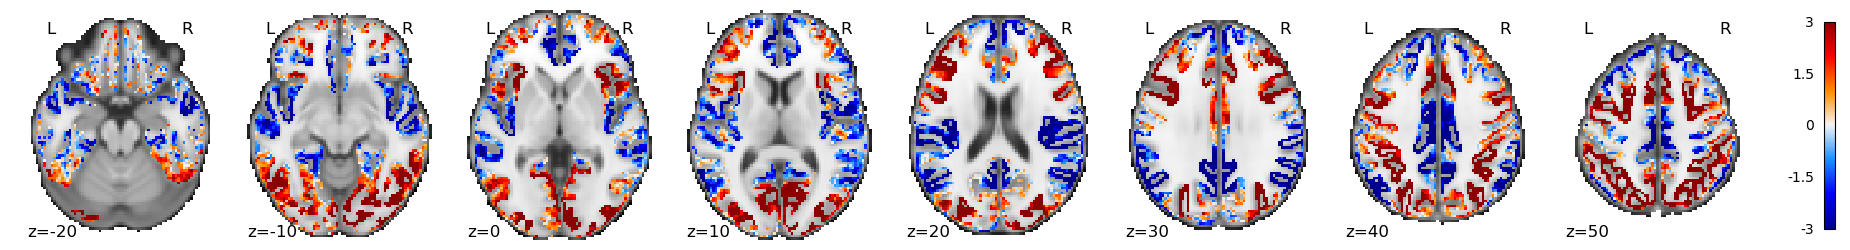

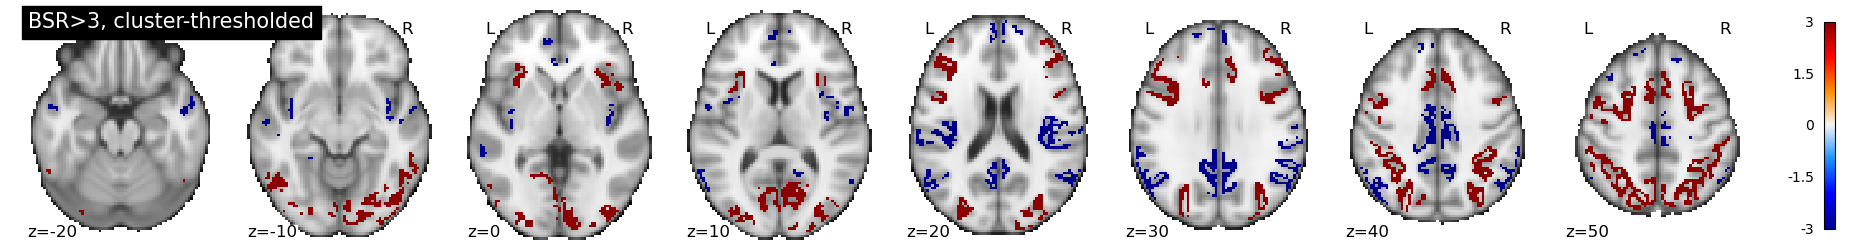

In [14]:
from nilearn import glm
from IPython.display import Image
from nilearn import datasets, image, regions

BSR_thr = 3
cluster_size =10
coords = (-20, -10, 0,10, 20, 30, 40,  50)

if group_mask[0] == 'PLS BOLD':
    BSR_masked_BOLD_YEO = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_'+contrast+ '.nii.gz'
    plotting.plot_img(BSR_masked_BOLD_YEO, bg_img = MNI_2mm_brain, cmap=BlueRed, cut_coords=coords, display_mode='z',colorbar = True, threshold=0, vmin = -3, vmax = 3, title= '')

BSR_cluster_thr = glm.threshold_stats_img(BSR_masked_BOLD_YEO, mask_img=None, alpha=0.05, threshold=BSR_thr, height_control=None, cluster_threshold=cluster_size, two_sided=True)
nib.save(BSR_cluster_thr[0],results_dir + '/N' + N_subj +'_BSR_meanPLS_BOLD_clusterBSR'+contrast+'.nii.gz')
BSR_cluster_thr_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_BOLD_clusterBSR'+contrast+'.nii.gz'
plotting.plot_img(BSR_cluster_thr_nii, bg_img = MNI_2mm_brain, cmap=BlueRed, cut_coords=coords, display_mode='z',colorbar = True, threshold=0, vmin = -3, vmax = 3, title= 'BSR>3, cluster-thresholded')

BSR_cluster_thr_nii_nib = nib.load(BSR_cluster_thr_nii)
inverse_MNI_affine = np.linalg.inv(BSR_cluster_thr_nii_nib.affine)


In [ ]:
##cluster-threshold PLS BOLD mask and mask with BSR>3, do this once!

##########################################
## task-negative clusters#################
##########################################

BSR_cluster_thr_arr = np.array(BSR_cluster_thr_nii_nib.dataobj)

BSR_cluster_thr_arr[BSR_cluster_thr_arr>0] =0

PLS_nii_neg = nib.Nifti1Image(BSR_cluster_thr_arr, BSR_cluster_thr_nii_nib.affine)
plotting.plot_img(PLS_nii_neg, cmap=BlueRed, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title=' PLS results')

if baseline == 'control':
    [cluster_4D_img, cluster_index] = regions.connected_regions(PLS_nii_neg, min_region_size=1000, extract_type='connected_components', smoothing_fwhm=6,  mask_img=None)
if baseline == 'rest':
    [cluster_4D_img, cluster_index] = regions.connected_regions(PLS_nii_neg, min_region_size=500, extract_type='connected_components', smoothing_fwhm=6,  mask_img=None)

print(image.load_img(cluster_4D_img).shape)

## save each cluster as separate nifti and plot
for cluster in range(0, (image.load_img(cluster_4D_img).shape[3])):
    cluster_image = image.index_img(cluster_4D_img, cluster)
    plotting.plot_img(cluster_image, cmap=BlueRed, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='ROI' + str(cluster+1))
    ## save
    nib.save(cluster_image,  results_dir + '/cluster' + str(cluster+1)+'.nii.gz')
    
#################################    
## binarize and order networks ##
#################################

##binarize regions
for ROI in range(0, (image.load_img(cluster_4D_img).shape[3])):
    cluster_img =   results_dir + '/cluster' + str(ROI+1)+'.nii.gz'
    cluster_img_bin =  results_dir + '/cluster' + str(ROI+1)+'_bin.nii.gz'
    ! fslmaths {cluster_img} -abs -bin {cluster_img_bin}   

from matplotlib.colors import LinearSegmentedColormap

colors = ["dodgerblue", "dodgerblue"]
Blue = LinearSegmentedColormap.from_list("mycmap", colors)

if baseline == 'control':## add the somatosensory regions together (upon visual inspection)
    ## add ROI 4 and ROI5
    ROI4 =  results_dir + '/cluster4_bin.nii.gz'
    ROI5 =  results_dir + '/cluster5_bin.nii.gz'
    ROI4_5 =  results_dir + '/cluster4_5_bin.nii.gz'
    ! fslmaths {ROI4} -add {ROI5} {ROI4_5}

    ## add ROI 7 and ROI 8 
    ROI7 =  results_dir + '/cluster7_bin.nii.gz'
    ROI8 =  results_dir + '/cluster8_bin.nii.gz'
    ROI7_8 =  results_dir + '/cluster7_8_bin.nii.gz'
    ! fslmaths {ROI7} -add {ROI8} {ROI7_8}

    ## create one image with all clusters
    all_clusters_nii = results_dir + '/all_negative_clusters_bin.nii.gz'
    ! fslmaths {results_dir + '/cluster1_bin.nii.gz'} -add {results_dir + '/cluster2_bin.nii.gz'} -add {results_dir + '/cluster3_bin.nii.gz'} -add {ROI4_5} -add  {results_dir + '/cluster6_bin.nii.gz'} -add {ROI7_8} -add {results_dir + '/cluster9_bin.nii.gz'} -add {results_dir + '/cluster10_bin.nii.gz'} -add {results_dir + '/cluster11_bin.nii.gz'} {all_clusters_nii}
    plotting.plot_img(all_clusters_nii, cmap=Blue, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters')
    plotting.plot_img(all_clusters_nii, cmap=Blue, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters',
                     output_file = results_dir + '/all_negative_clusters.pdf')

    ## rename regions
    shutil.copy(results_dir + '/cluster1_bin.nii.gz', results_dir + '/AU1_bin.nii.gz')
    shutil.copy(results_dir + '/cluster10_bin.nii.gz', results_dir + '/AU2_bin.nii.gz')
    shutil.copy(results_dir + '/cluster4_5_bin.nii.gz', results_dir + '/SM1_bin.nii.gz')
    shutil.copy(results_dir + '/cluster7_8_bin.nii.gz', results_dir + '/SM2_bin.nii.gz')
    shutil.copy(results_dir + '/cluster2_bin.nii.gz', results_dir + '/DMN1_bin.nii.gz')
    shutil.copy(results_dir + '/cluster11_bin.nii.gz', results_dir + '/DMN2_bin.nii.gz')
    shutil.copy(results_dir + '/cluster3_bin.nii.gz', results_dir + '/DMN3_bin.nii.gz')
    shutil.copy(results_dir + '/cluster6_bin.nii.gz', results_dir + '/DMN4_bin.nii.gz')
    shutil.copy(results_dir + '/cluster9_bin.nii.gz', results_dir + '/DMN5_bin.nii.gz')

if baseline == 'rest':## add the somatosensory regions together (upon visual inspection)
    ROI1 =  results_dir + '/cluster1_bin.nii.gz'
    ROI4 =  results_dir + '/cluster4_bin.nii.gz'
    ROI5 =  results_dir + '/cluster5_bin.nii.gz'
    ROI1_4_5 =  results_dir + '/cluster1_4_5_bin.nii.gz'
    ! fslmaths {ROI1} -add {ROI4} -add {ROI5} {ROI1_4_5}
    
    ROI3 =  results_dir + '/cluster3_bin.nii.gz'
    ROI13 =  results_dir + '/cluster13_bin.nii.gz'
    ROI3_13=  results_dir + '/cluster3_13_bin.nii.gz'
    ! fslmaths {ROI3} -add {ROI13} {ROI3_13}

    ROI8 =  results_dir + '/cluster8_bin.nii.gz'
    ROI10 =  results_dir + '/cluster10_bin.nii.gz'
    ROI8_10=  results_dir + '/cluster8_10_bin.nii.gz'
    ! fslmaths {ROI8} -add {ROI10}  {ROI8_10}
    
    ## create one image with all clusters
    all_clusters_nii = results_dir + '/all_negative_clusters_bin_rest.nii.gz'
    ! fslmaths {ROI8_10} -add {ROI1_4_5} -add {ROI3_13}  -add {results_dir + '/cluster2_bin.nii.gz'} -add {results_dir + '/cluster6_bin.nii.gz'} -add {results_dir + '/cluster7_bin.nii.gz'} -add {results_dir + '/cluster9_bin.nii.gz'} -add {results_dir + '/cluster11_bin.nii.gz'} -add {results_dir + '/cluster12_bin.nii.gz'} {all_clusters_nii}
    plotting.plot_img(all_clusters_nii, cmap=Blue, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters')
    plotting.plot_img(all_clusters_nii, cmap=Blue, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters',
                     output_file = results_dir + '/all_negative_clusters_rest.pdf')

    ## rename regions
    shutil.copy(results_dir + '/cluster1_4_5_bin.nii.gz', results_dir + '/NEG1_bin.nii.gz')
    shutil.copy(results_dir + '/cluster8_10_bin.nii.gz', results_dir + '/NEG2_bin.nii.gz')
    shutil.copy(results_dir + '/cluster3_13_bin.nii.gz', results_dir + '/NEG3_bin.nii.gz')
    shutil.copy(results_dir + '/cluster2_bin.nii.gz', results_dir + '/NEG6_bin.nii.gz')
    shutil.copy(results_dir + '/cluster6_bin.nii.gz', results_dir + '/NEG4_bin.nii.gz')
    shutil.copy(results_dir + '/cluster7_bin.nii.gz', results_dir + '/NEG5_bin.nii.gz')
    shutil.copy(results_dir + '/cluster9_bin.nii.gz', results_dir + '/NEG7_bin.nii.gz')
    shutil.copy(results_dir + '/cluster11_bin.nii.gz', results_dir + '/NEG8_bin.nii.gz')
    shutil.copy(results_dir + '/cluster12_bin.nii.gz', results_dir + '/NEG9_bin.nii.gz')
    
    
    
############################
## task-positive clusters ##
#############################

## all positives
BSR_cluster_thr_arr = np.array(BSR_cluster_thr_nii_nib.dataobj)
BSR_cluster_thr_arr[BSR_cluster_thr_arr<0] =0

PLS_nii_pos = nib.Nifti1Image(BSR_cluster_thr_arr, BSR_cluster_thr_nii_nib.affine)
plotting.plot_img(PLS_nii_pos, cmap=BlueRed, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords)

[cluster_4D_img, cluster_index] = regions.connected_regions(PLS_nii_pos, min_region_size=1200, extract_type='connected_components', smoothing_fwhm=6,  mask_img=None)

print(image.load_img(cluster_4D_img).shape)

## save each cluster as separate nifti and plot
for cluster in range(0, (image.load_img(cluster_4D_img).shape[3])):
    cluster_image = image.index_img(cluster_4D_img, cluster)
    plotting.plot_img(cluster_image, cmap=BlueRed, vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='ROI' + str(cluster+1))
    ## binarize
    nib.save(cluster_image,  results_dir + '/cluster' + str(cluster+1)+'.nii.gz')
    
#################################    
## binarize and order networks ##
#################################

for ROI in range(0, (image.load_img(cluster_4D_img).shape[3])):
    cluster_img =   results_dir + '/cluster' + str(ROI+1)+'.nii.gz'
    cluster_img_bin =  results_dir + '/cluster' + str(ROI+1)+'_bin.nii.gz'
    ! fslmaths {cluster_img} -abs -bin {cluster_img_bin}   


## add the somatosensory regions together (upon visual inspection)
## add ROI 4 and ROI5
if baseline == 'control':
    ROI2 =  results_dir + '/cluster2_bin.nii.gz'
    ROI3 =  results_dir + '/cluster3_bin.nii.gz'
    ROI5 =  results_dir + '/cluster5_bin.nii.gz'
    ROI2_3_5 =  results_dir + '/cluster2_3_5_bin.nii.gz'
    ! fslmaths {ROI2} -add {ROI3} -add {ROI5} {ROI2_3_5}

    ## add ROI 7 and ROI 8 
    ROI7 =  results_dir + '/cluster7_bin.nii.gz'
    ROI8 =  results_dir + '/cluster8_bin.nii.gz'
    ROI10 =  results_dir + '/cluster10_bin.nii.gz'
    ROI7_8_10 =  results_dir + '/cluster7_8_10_bin.nii.gz'
    ! fslmaths {ROI7} -add {ROI8} -add {ROI10} {ROI7_8_10}

    ## create one image with all clusters
    all_clusters_nii = results_dir + '/all_positive_clusters_bin.nii.gz'
    ! fslmaths {results_dir + '/cluster1_bin.nii.gz'} -add {ROI2_3_5} -add {results_dir + '/cluster4_bin.nii.gz'}  -add {results_dir + '/cluster6_bin.nii.gz'} -add {ROI7_8_10} -add {results_dir + '/cluster9_bin.nii.gz'} -add {results_dir + '/cluster11_bin.nii.gz'} -add {results_dir + '/cluster12_bin.nii.gz'} {all_clusters_nii}
    plotting.plot_img(all_clusters_nii, cmap='hot', vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters')
    plotting.plot_img(all_clusters_nii, cmap='hot', vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters',
                     output_file = results_dir + '/all_positive_clusters.pdf')

    ## rename regions
    shutil.copy(results_dir + '/cluster1_bin.nii.gz', results_dir + '/ROI1_bin.nii.gz')
    shutil.copy(results_dir + '/cluster7_8_10_bin.nii.gz', results_dir + '/ROI2_bin.nii.gz')
    shutil.copy(results_dir + '/cluster2_3_5_bin.nii.gz', results_dir + '/ROI3_bin.nii.gz')
    shutil.copy(results_dir + '/cluster11_bin.nii.gz', results_dir + '/ROI4_bin.nii.gz')
    shutil.copy(results_dir + '/cluster4_bin.nii.gz', results_dir + '/ROI5_bin.nii.gz')
    shutil.copy(results_dir + '/cluster12_bin.nii.gz', results_dir + '/ROI6_bin.nii.gz')
    shutil.copy(results_dir + '/cluster6_bin.nii.gz', results_dir + '/ROI7_bin.nii.gz')
    shutil.copy(results_dir + '/cluster9_bin.nii.gz', results_dir + '/ROI8_bin.nii.gz')

    ## create list with  cluster masks to be applied
    masks = [results_dir + '/ROI1_bin.nii.gz',
            results_dir + '/ROI2_bin.nii.gz',
            results_dir + '/ROI3_bin.nii.gz',
            results_dir + '/ROI4_bin.nii.gz',
            results_dir + '/ROI5_bin.nii.gz',
            results_dir + '/ROI6_bin.nii.gz',
            results_dir + '/ROI7_bin.nii.gz',
            results_dir + '/ROI8_bin.nii.gz']

    for mask in masks:
        plotting.plot_img(mask, cmap='hot', vmin=-7, vmax=7, bg_img=MNI_2mm_brain, threshold=0, display_mode='z', cut_coords=coords, title= os.path.basename(mask)[:-11])

if baseline == 'rest':
    ROI2 =  results_dir + '/cluster2_bin.nii.gz'
    ROI3 =  results_dir + '/cluster3_bin.nii.gz'
    ROI2_3 =  results_dir + '/cluster2_3_bin.nii.gz'
    ! fslmaths {ROI2} -add {ROI3}  {ROI2_3}

    ## add ROI 7 and ROI 8 
    ROI7 =  results_dir + '/cluster7_bin.nii.gz'
    ROI8 =  results_dir + '/cluster8_bin.nii.gz'
    ROI7_8=  results_dir + '/cluster7_8_bin.nii.gz'
    ! fslmaths {ROI7} -add {ROI8} {ROI7_8}

    ## create one image with all clusters
    all_clusters_nii = results_dir + '/all_positive_clusters_bin.nii.gz'
    ! fslmaths {results_dir + '/cluster1_bin.nii.gz'} -add {ROI2_3} -add {results_dir + '/cluster4_bin.nii.gz'}  -add {results_dir + '/cluster5_bin.nii.gz'} -add {results_dir + '/cluster6_bin.nii.gz'} -add {ROI7_8} {all_clusters_nii}
    plotting.plot_img(all_clusters_nii, cmap='hot', vmin=-7, vmax=7, bg_img=MNI_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters')
    plotting.plot_img(all_clusters_nii, cmap='hot', vmin=-7, vmax=7, bg_img=MNI_brain, threshold=0, display_mode='z', cut_coords=coords, title='all clusters',
                     output_file = results_dir + '/all_positive_clusters_rest.pdf')

    ## rename regions
    shutil.copy(results_dir + '/cluster1_bin.nii.gz', results_dir + '/ROI1_bin.nii.gz')
    shutil.copy(results_dir + '/cluster2_3_bin.nii.gz', results_dir + '/ROI2_bin.nii.gz')
    shutil.copy(results_dir + '/cluster4_bin.nii.gz', results_dir + '/ROI3_bin.nii.gz')
    shutil.copy(results_dir + '/cluster5_bin.nii.gz', results_dir + '/ROI4_bin.nii.gz')
    shutil.copy(results_dir + '/cluster6_bin.nii.gz', results_dir + '/ROI5_bin.nii.gz')
    shutil.copy(results_dir + '/cluster7_8_bin.nii.gz', results_dir + '/ROI6_bin.nii.gz')

    ## create list with  cluster masks to be applied
    masks = [results_dir + '/ROI1_bin.nii.gz',
            results_dir + '/ROI2_bin.nii.gz',
            results_dir + '/ROI3_bin.nii.gz',
            results_dir + '/ROI4_bin.nii.gz',
            results_dir + '/ROI5_bin.nii.gz',
            results_dir + '/ROI6_bin.nii.gz']

    for mask in masks:
        plotting.plot_img(mask, cmap='hot', vmin=-7, vmax=7, bg_img=MNI_brain, threshold=0, display_mode='z', cut_coords=coords, title= os.path.basename(mask)[:-11])


func
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p

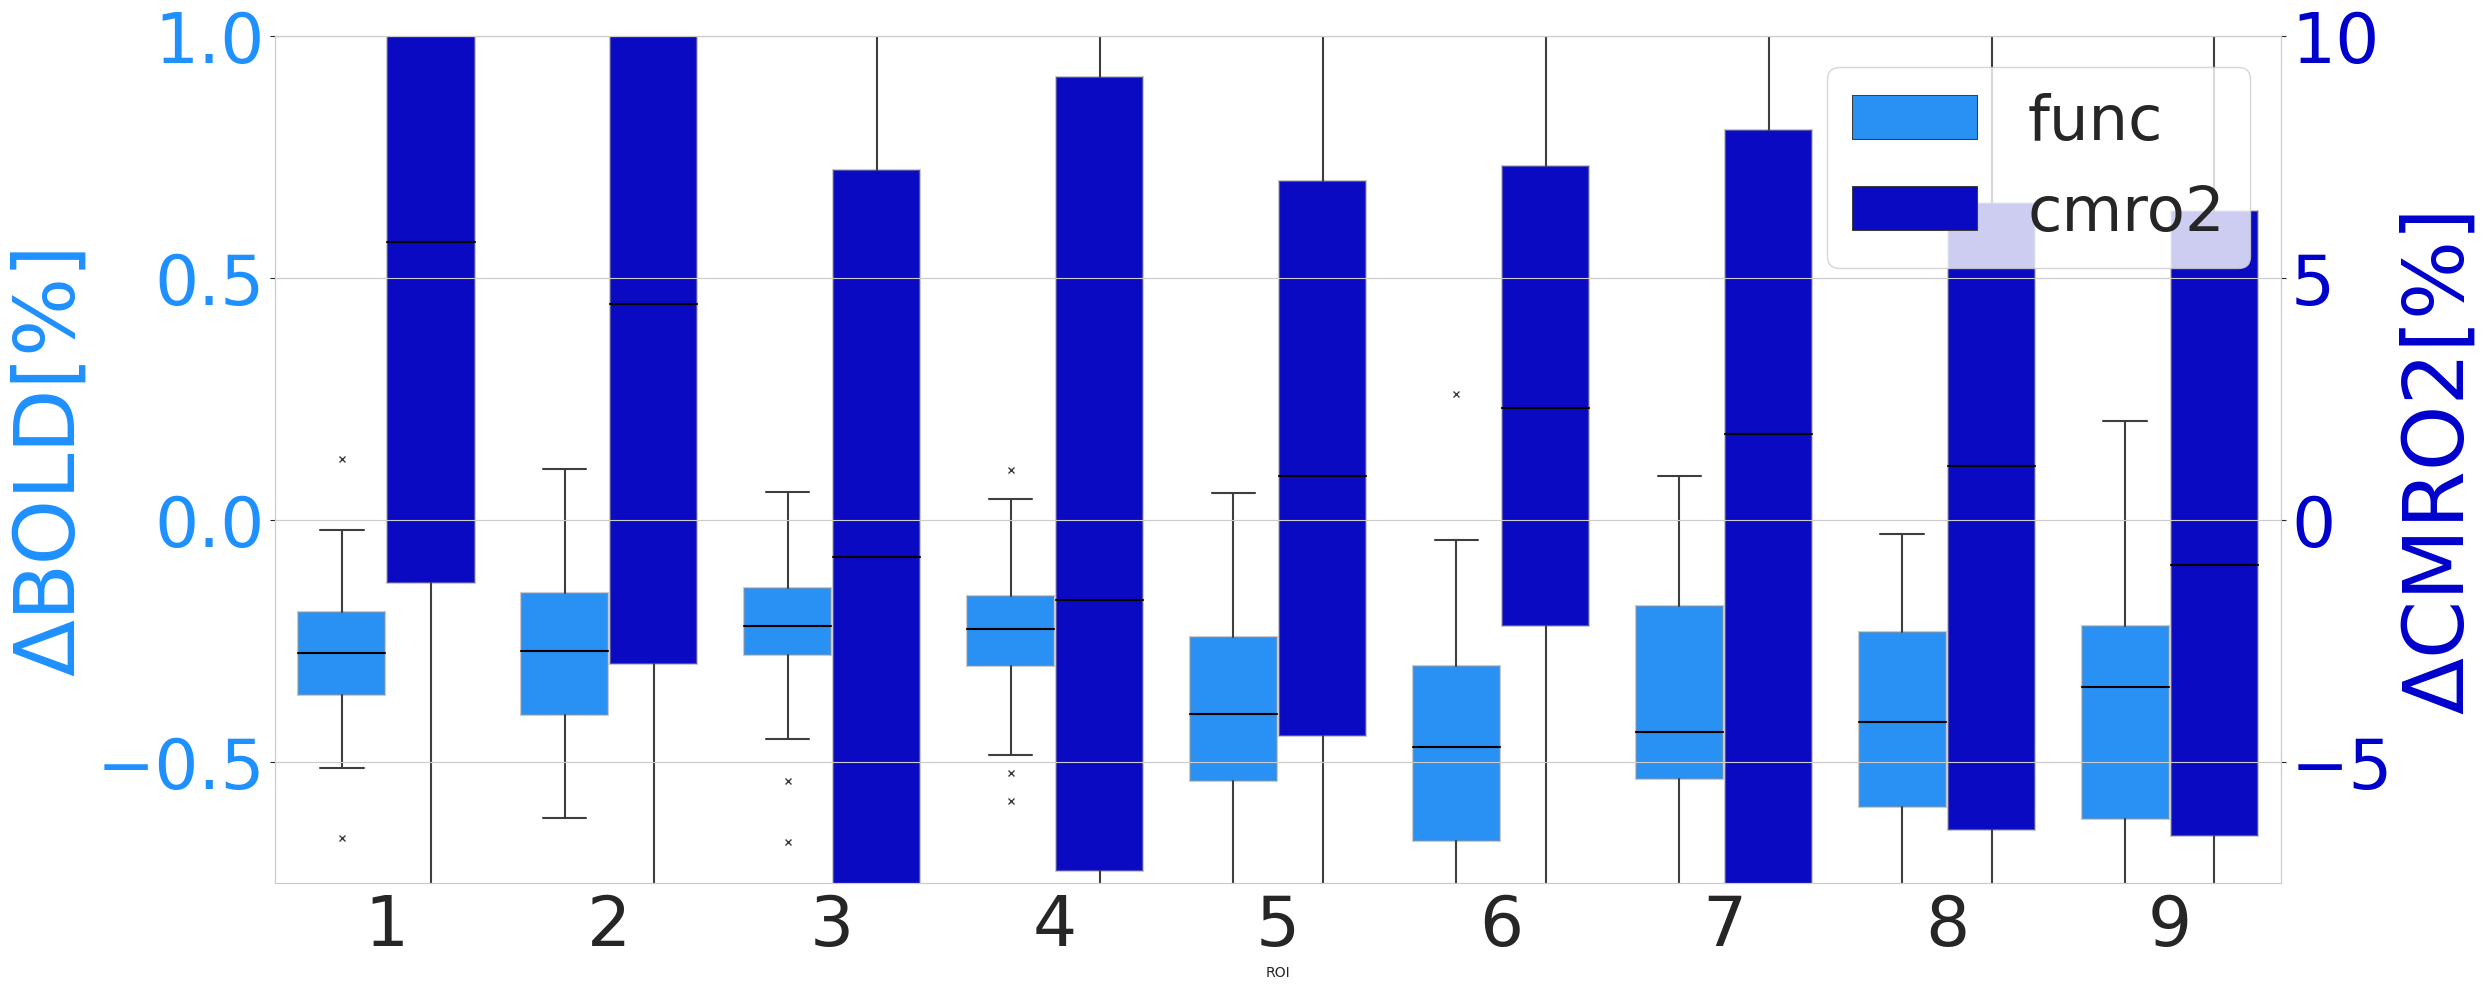

In [16]:
parameters = [ 'func', 'cmro2']

###################################
## plot negative clusters ##
#################################

if baseline == 'control':## create list with  cluster masks to be applied
    masks = [results_dir + '/AU1_bin.nii.gz',
            results_dir + '/AU2_bin.nii.gz',
            results_dir + '/SM1_bin.nii.gz',
            results_dir + '/SM2_bin.nii.gz',
            results_dir + '/DMN1_bin.nii.gz',
            results_dir + '/DMN2_bin.nii.gz',
            results_dir + '/DMN3_bin.nii.gz',
            results_dir + '/DMN4_bin.nii.gz',
            results_dir + '/DMN5_bin.nii.gz']

if baseline == 'rest':## create list with  cluster masks to be applied
    masks = [results_dir + '/NEG1_bin.nii.gz',
            results_dir + '/NEG2_bin.nii.gz',
            results_dir + '/NEG3_bin.nii.gz',
            results_dir + '/NEG4_bin.nii.gz',
            results_dir + '/NEG5_bin.nii.gz',
            results_dir + '/NEG6_bin.nii.gz',
            results_dir + '/NEG7_bin.nii.gz',
            results_dir + '/NEG8_bin.nii.gz',
            results_dir + '/NEG9_bin.nii.gz']

df_percchange_median = pd.DataFrame(columns=["ID","parameter", "ROI", "percchange"])


for par in parameters: 
    print(par)

    for m, mask in enumerate(masks):
        masker = input_data.NiftiMasker(mask_img = mask) 
        mask_img=masker.fit_transform(mask)

        percchange = np.zeros((len(sids), len(np.argwhere(mask_img))))
    
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            #load percent signal change image
            if par == 'func':
                #percchange_img = nib.load(dir_func_deriv + '/' + sub + '_task-' + task + baseline + '_space-MNI152_BOLD_percchange.nii.gz')
                percchange_img = nib.load(dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_desc-fmriprep_BOLD_percchange.nii.gz')
                #percchange_img = nib.load(dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_BOLD_percchange_desc-preproc.nii.gz')
            if par !='func' and par !='cmro2':
                task_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_' + par + '.nii.gz').dataobj)
                base_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_' + par + '.nii.gz').dataobj)
                percchange = (task_arr - base_arr) / base_arr * 100
                percchange_img = nib.Nifti1Image(percchange, nib.load(BSR_pos_nii_mask).affine)
            if par =='cmro2':
                if task == 'calc':
                    task_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-CBV_' + par + '.nii.gz').dataobj)
                if task !='calc':
                    task_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-orig_' + par + '.nii.gz').dataobj)    
                base_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_' + par + '.nii.gz').dataobj)
                percchange = (task_arr - base_arr) / base_arr * 100               
                percchange_img = nib.Nifti1Image(percchange,  nib.load(BSR_pos_nii_mask).affine)
                
            ## mask with ROI    
            percchange = masker.fit_transform(percchange_img)
            percchange = percchange[percchange!=0]
            
            ## different axis for CMRO2 / CBV
            if par == 'cmro2' or par == 'cbf':
                percchange = percchange/10
            
            par_name=par
            
            mask_name=os.path.basename(mask)[:-11]
            new_row = {'ID':ID, 'parameter':par_name, 'ROI': mask_name, 'percchange':np.nanmedian(percchange)}
            df_percchange_median = df_percchange_median.append(new_row, ignore_index = True)
            
##plot as barplot ##
fontsize=50
sns.set_style("whitegrid")

Blue_palette=["dodgerblue", "mediumblue"]

fig, ax1= plt.subplots(1, figsize=(25,10))

ax1 = sns.barplot(data=df_percchange_median, x="ROI", y="percchange", hue="parameter",  estimator=np.median, ci=95, capsize=.07, n_boot=2000, 
                  errwidth=5, saturation=0.9, alpha=0.7, palette=Blue_palette)
#ax1 = sns.boxplot(x="ROI", y="percchange", hue="parameter", data=df_percchange_median, saturation=0.9,ax=ax1,
#                   palette=Blue_palette, boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
#                   medianprops={"color": "black"})
ax1 = sns.stripplot(data = df_percchange_median, x="ROI", y="percchange", hue="parameter",  palette=Blue_palette, dodge=True,marker='o', 
                    size=8, alpha=0.6)
ax1.set_ylim(-2, 3)
ax1.set_xlim(-0.5, 8.5)
ax1.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9'], fontsize=fontsize+10)
ax1.set_yticks([-2,  -1,0,  1, 2, 3])
ax1.hlines(0,-0.5, 9.5, color='red', linestyle='solid', linewidth = 3)
ax1.set_ylabel('ΔBOLD[%]', fontsize=fontsize+10, color='dodgerblue')  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor='dodgerblue')
#ax1.legend(fontsize=fontsize-5,loc="upper right")
ax1.legend([], [], frameon=False)
## add asterix for significance based on visual inspection (error-bars do not cross zero), not possible to access CIs in seaborn
ax1.text(0, 3, '*', color='grey', fontsize=fontsize)
ax1.text(1, 3, '*', color='grey', fontsize=fontsize)
            
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'mediumblue'
ax2.set_ylabel('CMRO2', color=color)  # we already handled the x-label with ax1
#ax2.plotsns.barplot(x="ROI", y="percchange", hue="parameter", data=df_percchange_median, estimator=np.median, ci=95, capsize=.05, n_boot=2000, errwidth=1,
#                 saturation=0.9, alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(-0.5, 8.5)
ax2.set_ylim(-20, 30)
ax2.set_ylabel('ΔCMRO2[%]', fontsize=fontsize+10)
ax2.set_yticks([-20, -10, 0, 10,  20, 30])

#set x-tick and y-ticke label size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(fontsize)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

fig.savefig(results_dir + '/all_negative_ROIs_CBF_CMRO2_BOLD_baseline'+baseline+'.png', dpi=300)

func
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p

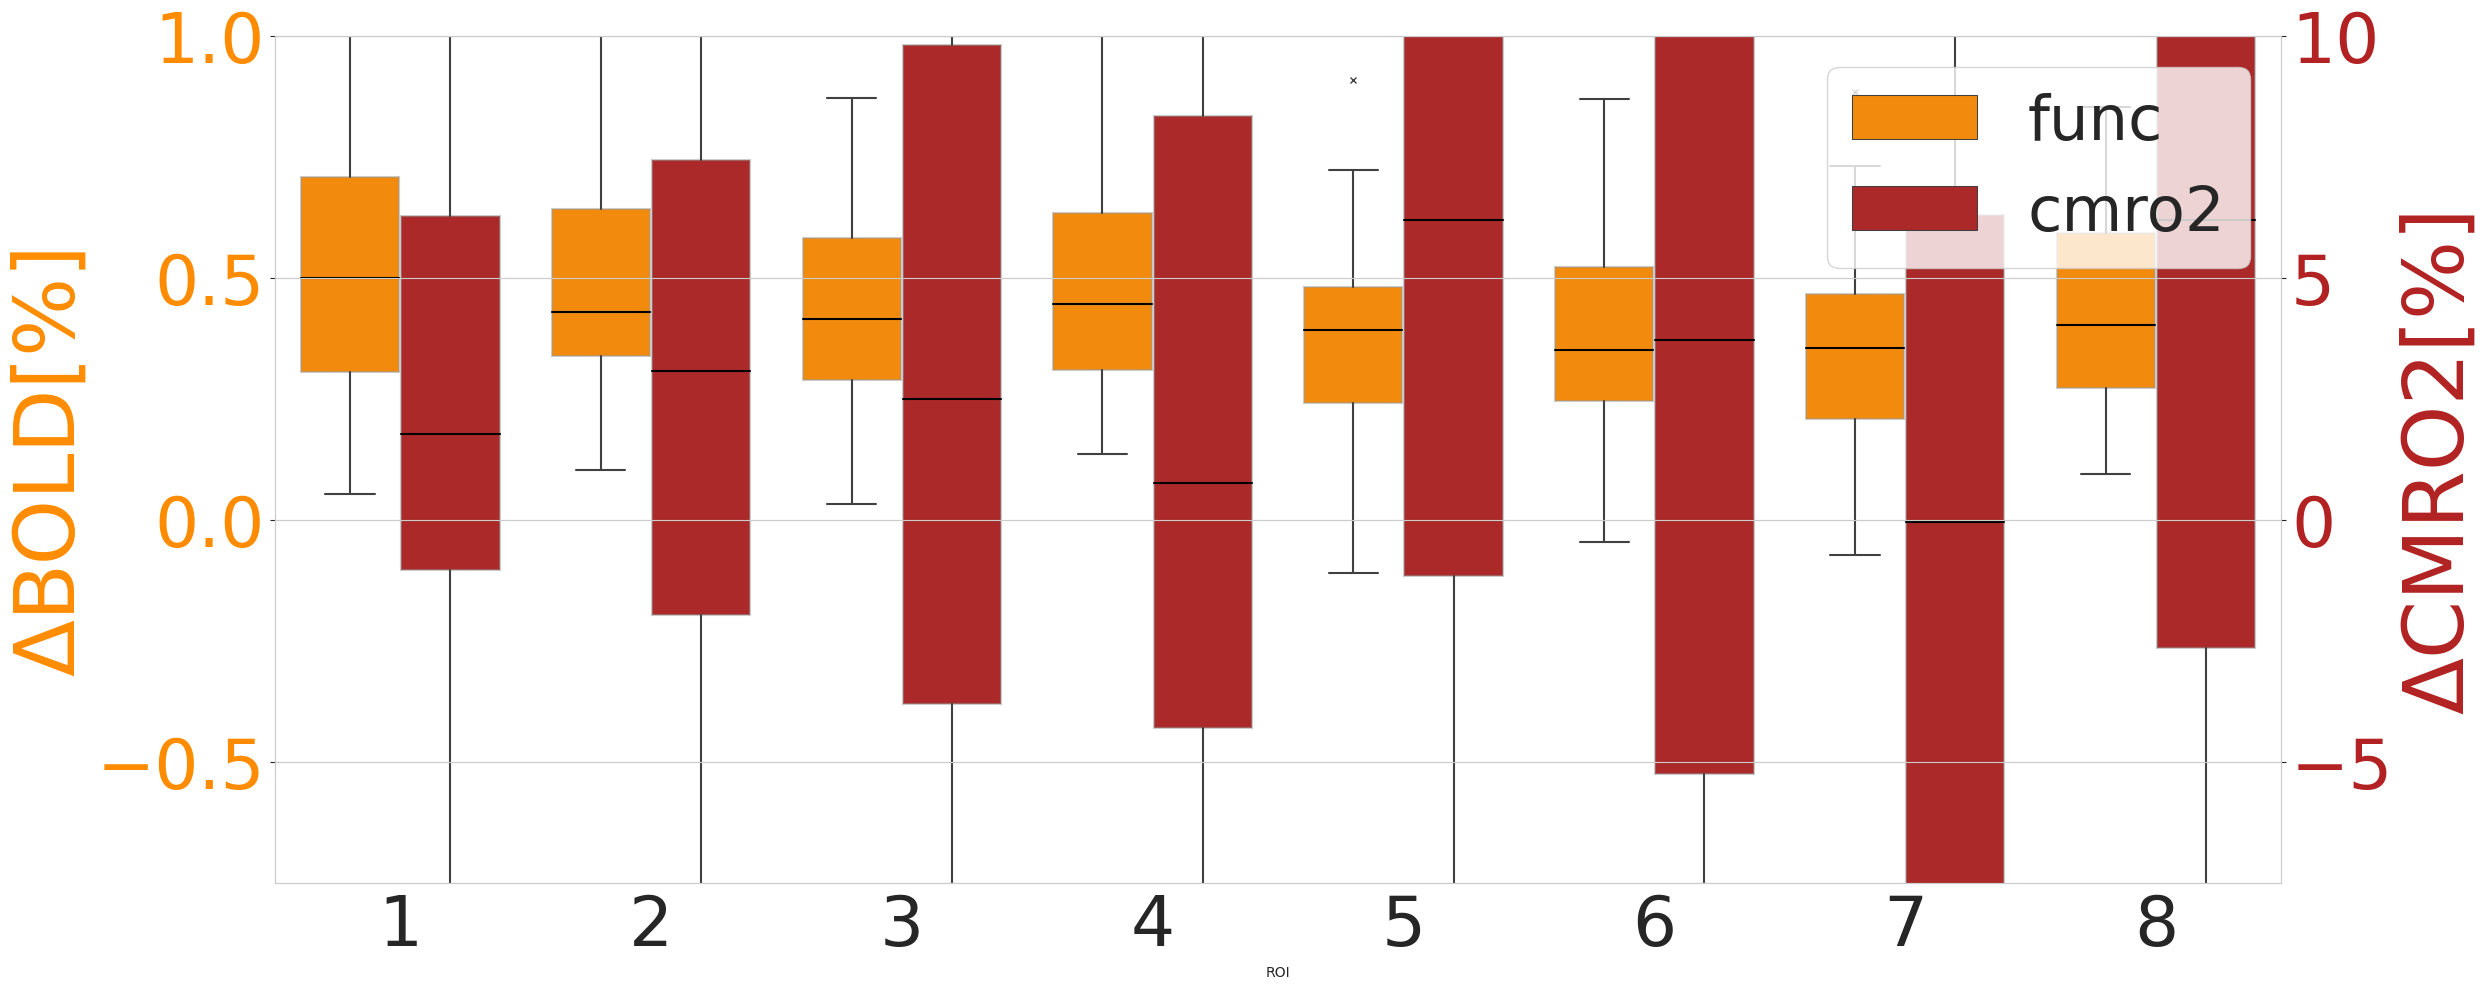

In [57]:
parameters = [ 'func', 'cmro2']

###################################
## plot positive clusters ##
#################################

## create list with  cluster masks to be applied
if baseline == 'control':
    masks = [results_dir + '/ROI1_bin.nii.gz',
            results_dir + '/ROI2_bin.nii.gz',
            results_dir + '/ROI3_bin.nii.gz',
            results_dir + '/ROI4_bin.nii.gz',
            results_dir + '/ROI5_bin.nii.gz',
            results_dir + '/ROI6_bin.nii.gz',
            results_dir + '/ROI7_bin.nii.gz',
            results_dir + '/ROI8_bin.nii.gz']

## create list with  cluster masks to be applied
if baseline == 'rest':
    masks = [results_dir + '/ROI1_bin.nii.gz',
            results_dir + '/ROI2_bin.nii.gz',
            results_dir + '/ROI3_bin.nii.gz',
            results_dir + '/ROI4_bin.nii.gz',
            results_dir + '/ROI5_bin.nii.gz',
            results_dir + '/ROI6_bin.nii.gz']


df_percchange_median = pd.DataFrame(columns=["ID","parameter", "ROI", "percchange"])


for par in parameters: 
    print(par)
    for m, mask in enumerate(masks):
        masker = input_data.NiftiMasker(mask_img = mask) 
        mask_img=masker.fit_transform(mask)

        percchange = np.zeros((len(sids), len(np.argwhere(mask_img))))
    
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)

            sub_dir = os.path.join(data_dir, sub)

            dir_anat = os.path.join(sub_dir, 'anat')
            dir_func = os.path.join(sub_dir, 'func')
            dir_perf = os.path.join(sub_dir, 'perf')

            dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
            dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
            dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            #load percent signal change image
            if par == 'func':
                percchange_img = nib.load(dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_desc-fmriprep_BOLD_percchange.nii.gz')
            if par !='func' and par !='cmro2':
                task_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_' + par + '.nii.gz').dataobj)
                base_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_' + par + '.nii.gz').dataobj)
                percchange = (task_arr - base_arr) / base_arr * 100
                percchange_img = nib.Nifti1Image(percchange, nib.load(BSR_pos_nii_mask).affine)
            if par =='cmro2':
                if task == 'calc':
                    task_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-CBV_' + par + '.nii.gz').dataobj)
                if task !='calc':
                    task_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-orig_' + par + '.nii.gz').dataobj)    
                base_arr = np.array(nib.load( dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_' + par + '.nii.gz').dataobj)
                percchange = (task_arr - base_arr) / base_arr * 100               
                percchange_img = nib.Nifti1Image(percchange,  nib.load(BSR_pos_nii_mask).affine)

                
            ## mask with ROI    
            percchange = masker.fit_transform(percchange_img)
            percchange = percchange[percchange!=0]
            
            ## different axis for CMRO2 / CBV
            if par == 'cmro2' or par == 'cbf':
                percchange = percchange/10
            par_name=par
            
            mask_name=os.path.basename(mask)[:-11]
            new_row = {'ID':ID, 'parameter':par_name, 'ROI': mask_name, 'percchange':np.nanmedian(percchange)}
            df_percchange_median = df_percchange_median.append(new_row, ignore_index = True)
            
##plot as barplot ##

fontsize=50
sns.set_style("whitegrid")

#Red_palette=["navajowhite", "darkorange", "firebrick"]
Red_palette=[ "darkorange", "firebrick"]

fig, ax1= plt.subplots(1, figsize=(25,10))

ax1 = sns.barplot(data=df_percchange_median, x="ROI", y="percchange", hue="parameter",  estimator=np.median, ci=95, capsize=.07, n_boot=2000, 
                  errwidth=5, saturation=0.9, alpha=0.7, palette=Red_palette)
ax1 = sns.stripplot(data = df_percchange_median, x="ROI", y="percchange", hue="parameter",  palette=Red_palette, dodge=True,marker='o', 
                    size=8, alpha=0.6)
ax1.hlines(0,-0.5, 9.5, color='red', linestyle='solid', linewidth = 3)

ax1.set_ylim(-2, 3)
ax1.set_xlim(-0.5, 7.5)
ax1.set_yticks([-2, -1,  0, 1, 2, 3])
if baseline == 'control':
    ax1.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8'], fontsize=fontsize+10)
if baseline == 'rest':
    ax1.set_xticklabels(['1', '2', '3', '4', '5', '6'], fontsize=fontsize+10)
ax1.set_ylabel('ΔBOLD[%]', fontsize=fontsize+10, color='darkorange')  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor='darkorange')
#ax1.legend(fontsize=fontsize-5,loc="upper right")
ax1.legend([], [], frameon=False)
## add asterix for significance based on visual inspection (error-bars do not cross zero), not possible to access CIs in seaborn
ax1.text(0, 3, '*', color='grey', fontsize=fontsize)
ax1.text(4, 3, '*', color='grey', fontsize=fontsize)
ax1.text(5, 3, '*', color='grey', fontsize=fontsize)

            
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'firebrick'
#ax2.plotsns.barplot(x="ROI", y="percchange", hue="parameter", data=df_percchange_median, estimator=np.median, ci=95, capsize=.05, n_boot=2000, errwidth=1,
#                 saturation=0.9, alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-20, 30)
ax2.set_ylabel('ΔCMRO2[%]', fontsize=fontsize+10, color=color)
ax2.set_yticks([-20, -10, 0, 10, 20, 30])
ax1.set_xlim(-0.5, 7.5)

#set x-tick and y-ticke label size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(fontsize)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

fig.savefig(results_dir + '/all_positive_ROIs_CBF_CMRO2_BOLD.png', dpi=300)